In [148]:
!pip install transformers --upgrade
!pip install sentencepiece

import os
os.environ['CUDA_VISIBLE_DEVICES'] ='0'


In [149]:
!pip install transformers sentencepiece datasets

In [150]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
sns.set()

In [151]:
from transformers import AutoModelForSeq2SeqLM

model_repo = 'google/mt5-small'  # Define model_repo before using it
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)

max_seq_len = model.config.max_length
device = torch.device("cpu")

model = model.to(device)
# model = model.cuda()

In [152]:
!pip install sentencepiece


In [153]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

In [154]:
input_sent = 'Here is our test sentence!'
token_ids = tokenizer.encode(input_sent, return_tensors='pt')
token_ids

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[     0, 250099,      1]])
<pad> <extra_id_0></s>


In [155]:
dataset = load_dataset('alt')

In [156]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [157]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'ja': '<jp>',
    'zh': '<zh>'
}

In [158]:
token_ids = tokenizer.encode(
    "example input string", return_tensors='pt',
    padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tensor([[11310, 13037, 11306,     1,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])


In [159]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)

  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [160]:
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

▁< zh > フランス の パリ 、 パル ク ・ デ ・ プラン ス で 行われた 2007 年 ラグビー ワールド カップ の プール C で 、 イタリア は 31 対 5 で ポル ト ガル を下 した 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁ 意大利 在 法国 巴黎 王子 公园 体育 场 举办 的 2007 年 橄 榄 球 世界杯 C 组 以 3 1-5 击 败 葡萄 牙 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

In [161]:
n_epochs = 10
batch_size = 10
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [162]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [163]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model = model.cuda()
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [164]:
test_loss = eval_model(model, test_dataset)


In [165]:
losses=[]

for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):

    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()


    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

  test_loss = eval_model(model, test_dataset)
  print('Test loss of {:.3f}'.format(test_loss))

<ipython-input-165-1d46acbf0973>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1809 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 17.198 | lr: 0.0001388888888888889
Epoch: 1 | Step: 100 | Avg. loss: 7.582 | lr: 0.0002777777777777778
Epoch: 1 | Step: 150 | Avg. loss: 5.871 | lr: 0.0004166666666666667
Epoch: 1 | Step: 200 | Avg. loss: 4.900 | lr: 0.0004994416527079843
Epoch: 1 | Step: 250 | Avg. loss: 4.454 | lr: 0.0004980457844779453
Epoch: 1 | Step: 300 | Avg. loss: 4.202 | lr: 0.0004966499162479063
Epoch: 1 | Step: 350 | Avg. loss: 4.067 | lr: 0.0004952540480178671
Epoch: 1 | Step: 400 | Avg. loss: 4.006 | lr: 0.0004938581797878281
Epoch: 1 | Step: 450 | Avg. loss: 3.946 | lr: 0.0004924623115577889
Epoch: 1 | Step: 500 | Avg. loss: 3.774 | lr: 0.0004910664433277499
Epoch: 1 | Step: 550 | Avg. loss: 3.719 | lr: 0.0004896705750977108
Epoch: 1 | Step: 600 | Avg. loss: 3.852 | lr: 0.00048827470686767173
Epoch: 1 | Step: 650 | Avg. loss: 3.742 | lr: 0.0004868788386376326
Epoch: 1 | Step: 700 | Avg. loss: 3.641 | lr: 0.00048548297040759355
Epoch: 1 | Step: 750 | Avg. loss: 3.618 | lr: 

  0%|          | 0/1809 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 3.087 | lr: 0.00045312674483528756
Epoch: 2 | Step: 100 | Avg. loss: 3.086 | lr: 0.00045173087660524847
Epoch: 2 | Step: 150 | Avg. loss: 3.080 | lr: 0.0004503350083752094
Epoch: 2 | Step: 200 | Avg. loss: 3.048 | lr: 0.0004489391401451703
Epoch: 2 | Step: 250 | Avg. loss: 3.103 | lr: 0.0004475432719151312
Epoch: 2 | Step: 300 | Avg. loss: 3.120 | lr: 0.00044614740368509217
Epoch: 2 | Step: 350 | Avg. loss: 3.134 | lr: 0.00044475153545505303
Epoch: 2 | Step: 400 | Avg. loss: 3.083 | lr: 0.000443355667225014
Epoch: 2 | Step: 450 | Avg. loss: 3.092 | lr: 0.0004419597989949749
Epoch: 2 | Step: 500 | Avg. loss: 2.997 | lr: 0.00044056393076493576
Epoch: 2 | Step: 550 | Avg. loss: 3.047 | lr: 0.00043916806253489673
Epoch: 2 | Step: 600 | Avg. loss: 3.109 | lr: 0.00043777219430485764
Epoch: 2 | Step: 650 | Avg. loss: 3.075 | lr: 0.00043637632607481855
Epoch: 2 | Step: 700 | Avg. loss: 3.069 | lr: 0.00043498045784477946
Epoch: 2 | Step: 750 | Avg. loss: 3.074 |

  0%|          | 0/1809 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg. loss: 2.813 | lr: 0.00040262423227247347
Epoch: 3 | Step: 100 | Avg. loss: 2.859 | lr: 0.0004012283640424344
Epoch: 3 | Step: 150 | Avg. loss: 2.778 | lr: 0.00039983249581239535
Epoch: 3 | Step: 200 | Avg. loss: 2.770 | lr: 0.0003984366275823562
Epoch: 3 | Step: 250 | Avg. loss: 2.851 | lr: 0.00039704075935231717
Epoch: 3 | Step: 300 | Avg. loss: 2.901 | lr: 0.0003956448911222781
Epoch: 3 | Step: 350 | Avg. loss: 2.816 | lr: 0.00039424902289223894
Epoch: 3 | Step: 400 | Avg. loss: 2.901 | lr: 0.0003928531546621999
Epoch: 3 | Step: 450 | Avg. loss: 2.817 | lr: 0.0003914572864321608
Epoch: 3 | Step: 500 | Avg. loss: 2.775 | lr: 0.00039006141820212173
Epoch: 3 | Step: 550 | Avg. loss: 2.788 | lr: 0.00038866554997208264
Epoch: 3 | Step: 600 | Avg. loss: 2.867 | lr: 0.0003872696817420436
Epoch: 3 | Step: 650 | Avg. loss: 2.793 | lr: 0.00038587381351200446
Epoch: 3 | Step: 700 | Avg. loss: 2.861 | lr: 0.00038447794528196537
Epoch: 3 | Step: 750 | Avg. loss: 2.835 |

  0%|          | 0/1809 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg. loss: 2.604 | lr: 0.0003521217197096594
Epoch: 4 | Step: 100 | Avg. loss: 2.533 | lr: 0.00035072585147962035
Epoch: 4 | Step: 150 | Avg. loss: 2.603 | lr: 0.00034932998324958126
Epoch: 4 | Step: 200 | Avg. loss: 2.561 | lr: 0.0003479341150195421
Epoch: 4 | Step: 250 | Avg. loss: 2.680 | lr: 0.0003465382467895031
Epoch: 4 | Step: 300 | Avg. loss: 2.674 | lr: 0.000345142378559464
Epoch: 4 | Step: 350 | Avg. loss: 2.628 | lr: 0.0003437465103294249
Epoch: 4 | Step: 400 | Avg. loss: 2.670 | lr: 0.0003423506420993858
Epoch: 4 | Step: 450 | Avg. loss: 2.608 | lr: 0.0003409547738693468
Epoch: 4 | Step: 500 | Avg. loss: 2.663 | lr: 0.00033955890563930764
Epoch: 4 | Step: 550 | Avg. loss: 2.575 | lr: 0.00033816303740926855
Epoch: 4 | Step: 600 | Avg. loss: 2.664 | lr: 0.0003367671691792295
Epoch: 4 | Step: 650 | Avg. loss: 2.568 | lr: 0.00033537130094919037
Epoch: 4 | Step: 700 | Avg. loss: 2.596 | lr: 0.00033397543271915134
Epoch: 4 | Step: 750 | Avg. loss: 2.568 | lr

  0%|          | 0/1809 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg. loss: 2.439 | lr: 0.00030161920714684534
Epoch: 5 | Step: 100 | Avg. loss: 2.385 | lr: 0.00030022333891680626
Epoch: 5 | Step: 150 | Avg. loss: 2.440 | lr: 0.00029882747068676717
Epoch: 5 | Step: 200 | Avg. loss: 2.485 | lr: 0.0002974316024567281
Epoch: 5 | Step: 250 | Avg. loss: 2.410 | lr: 0.000296035734226689
Epoch: 5 | Step: 300 | Avg. loss: 2.504 | lr: 0.00029463986599664996
Epoch: 5 | Step: 350 | Avg. loss: 2.538 | lr: 0.0002932439977666108
Epoch: 5 | Step: 400 | Avg. loss: 2.492 | lr: 0.0002918481295365717
Epoch: 5 | Step: 450 | Avg. loss: 2.493 | lr: 0.0002904522613065327
Epoch: 5 | Step: 500 | Avg. loss: 2.416 | lr: 0.00028905639307649355
Epoch: 5 | Step: 550 | Avg. loss: 2.497 | lr: 0.0002876605248464545
Epoch: 5 | Step: 600 | Avg. loss: 2.520 | lr: 0.0002862646566164154
Epoch: 5 | Step: 650 | Avg. loss: 2.515 | lr: 0.00028486878838637633
Epoch: 5 | Step: 700 | Avg. loss: 2.482 | lr: 0.00028347292015633725
Epoch: 5 | Step: 750 | Avg. loss: 2.488 | l

  0%|          | 0/1809 [00:00<?, ?it/s]

Epoch: 6 | Step: 50 | Avg. loss: 2.297 | lr: 0.00025111669458403125
Epoch: 6 | Step: 100 | Avg. loss: 2.287 | lr: 0.00024972082635399217
Epoch: 6 | Step: 150 | Avg. loss: 2.282 | lr: 0.00024832495812395313
Epoch: 6 | Step: 200 | Avg. loss: 2.289 | lr: 0.00024692908989391404
Epoch: 6 | Step: 250 | Avg. loss: 2.297 | lr: 0.00024553322166387495
Epoch: 6 | Step: 300 | Avg. loss: 2.345 | lr: 0.00024413735343383587
Epoch: 6 | Step: 350 | Avg. loss: 2.257 | lr: 0.00024274148520379678
Epoch: 6 | Step: 400 | Avg. loss: 2.300 | lr: 0.0002413456169737577
Epoch: 6 | Step: 450 | Avg. loss: 2.305 | lr: 0.0002399497487437186
Epoch: 6 | Step: 500 | Avg. loss: 2.331 | lr: 0.0002385538805136795
Epoch: 6 | Step: 550 | Avg. loss: 2.269 | lr: 0.00023715801228364042
Epoch: 6 | Step: 600 | Avg. loss: 2.373 | lr: 0.00023576214405360136
Epoch: 6 | Step: 650 | Avg. loss: 2.327 | lr: 0.00023436627582356227
Epoch: 6 | Step: 700 | Avg. loss: 2.336 | lr: 0.00023297040759352318
Epoch: 6 | Step: 750 | Avg. loss: 2.25

  0%|          | 0/1809 [00:00<?, ?it/s]

Epoch: 7 | Step: 50 | Avg. loss: 2.189 | lr: 0.0002006141820212172
Epoch: 7 | Step: 100 | Avg. loss: 2.166 | lr: 0.0001992183137911781
Epoch: 7 | Step: 150 | Avg. loss: 2.135 | lr: 0.00019782244556113904
Epoch: 7 | Step: 200 | Avg. loss: 2.140 | lr: 0.00019642657733109995
Epoch: 7 | Step: 250 | Avg. loss: 2.191 | lr: 0.00019503070910106086
Epoch: 7 | Step: 300 | Avg. loss: 2.107 | lr: 0.0001936348408710218
Epoch: 7 | Step: 350 | Avg. loss: 2.241 | lr: 0.00019223897264098269
Epoch: 7 | Step: 400 | Avg. loss: 2.221 | lr: 0.0001908431044109436
Epoch: 7 | Step: 450 | Avg. loss: 2.236 | lr: 0.00018944723618090454
Epoch: 7 | Step: 500 | Avg. loss: 2.238 | lr: 0.00018805136795086545
Epoch: 7 | Step: 550 | Avg. loss: 2.223 | lr: 0.00018665549972082636
Epoch: 7 | Step: 600 | Avg. loss: 2.162 | lr: 0.0001852596314907873
Epoch: 7 | Step: 650 | Avg. loss: 2.201 | lr: 0.00018386376326074818
Epoch: 7 | Step: 700 | Avg. loss: 2.151 | lr: 0.0001824678950307091
Epoch: 7 | Step: 750 | Avg. loss: 2.172 |

  0%|          | 0/1809 [00:00<?, ?it/s]

Epoch: 8 | Step: 50 | Avg. loss: 2.077 | lr: 0.00015011166945840313
Epoch: 8 | Step: 100 | Avg. loss: 1.978 | lr: 0.00014871580122836404
Epoch: 8 | Step: 150 | Avg. loss: 1.955 | lr: 0.00014731993299832498
Epoch: 8 | Step: 200 | Avg. loss: 2.043 | lr: 0.00014592406476828586
Epoch: 8 | Step: 250 | Avg. loss: 2.033 | lr: 0.00014452819653824677
Epoch: 8 | Step: 300 | Avg. loss: 1.962 | lr: 0.0001431323283082077
Epoch: 8 | Step: 350 | Avg. loss: 2.058 | lr: 0.00014173646007816862
Epoch: 8 | Step: 400 | Avg. loss: 1.995 | lr: 0.00014034059184812953
Epoch: 8 | Step: 450 | Avg. loss: 2.050 | lr: 0.00013894472361809047
Epoch: 8 | Step: 500 | Avg. loss: 2.043 | lr: 0.00013754885538805136
Epoch: 8 | Step: 550 | Avg. loss: 2.002 | lr: 0.00013615298715801227
Epoch: 8 | Step: 600 | Avg. loss: 2.019 | lr: 0.0001347571189279732
Epoch: 8 | Step: 650 | Avg. loss: 2.107 | lr: 0.00013336125069793412
Epoch: 8 | Step: 700 | Avg. loss: 2.016 | lr: 0.00013196538246789503
Epoch: 8 | Step: 750 | Avg. loss: 2.0

  0%|          | 0/1809 [00:00<?, ?it/s]

Epoch: 9 | Step: 50 | Avg. loss: 1.874 | lr: 9.960915689558905e-05
Epoch: 9 | Step: 100 | Avg. loss: 1.868 | lr: 9.821328866554998e-05
Epoch: 9 | Step: 150 | Avg. loss: 1.858 | lr: 9.68174204355109e-05
Epoch: 9 | Step: 200 | Avg. loss: 1.880 | lr: 9.54215522054718e-05
Epoch: 9 | Step: 250 | Avg. loss: 1.918 | lr: 9.402568397543272e-05
Epoch: 9 | Step: 300 | Avg. loss: 1.908 | lr: 9.262981574539365e-05
Epoch: 9 | Step: 350 | Avg. loss: 1.899 | lr: 9.123394751535455e-05
Epoch: 9 | Step: 400 | Avg. loss: 1.859 | lr: 8.983807928531547e-05
Epoch: 9 | Step: 450 | Avg. loss: 1.926 | lr: 8.844221105527638e-05
Epoch: 9 | Step: 500 | Avg. loss: 1.993 | lr: 8.70463428252373e-05
Epoch: 9 | Step: 550 | Avg. loss: 1.900 | lr: 8.565047459519822e-05
Epoch: 9 | Step: 600 | Avg. loss: 1.946 | lr: 8.425460636515913e-05
Epoch: 9 | Step: 650 | Avg. loss: 1.859 | lr: 8.285873813512004e-05
Epoch: 9 | Step: 700 | Avg. loss: 1.927 | lr: 8.146286990508097e-05
Epoch: 9 | Step: 750 | Avg. loss: 1.926 | lr: 8.0067

  0%|          | 0/1809 [00:00<?, ?it/s]

Epoch: 10 | Step: 50 | Avg. loss: 1.764 | lr: 4.910664433277499e-05
Epoch: 10 | Step: 100 | Avg. loss: 1.882 | lr: 4.77107761027359e-05
Epoch: 10 | Step: 150 | Avg. loss: 1.780 | lr: 4.6314907872696824e-05
Epoch: 10 | Step: 200 | Avg. loss: 1.811 | lr: 4.4919039642657736e-05
Epoch: 10 | Step: 250 | Avg. loss: 1.874 | lr: 4.352317141261865e-05
Epoch: 10 | Step: 300 | Avg. loss: 1.778 | lr: 4.2127303182579565e-05
Epoch: 10 | Step: 350 | Avg. loss: 1.832 | lr: 4.073143495254048e-05
Epoch: 10 | Step: 400 | Avg. loss: 1.807 | lr: 3.9335566722501395e-05
Epoch: 10 | Step: 450 | Avg. loss: 1.843 | lr: 3.793969849246231e-05
Epoch: 10 | Step: 500 | Avg. loss: 1.836 | lr: 3.654383026242323e-05
Epoch: 10 | Step: 550 | Avg. loss: 1.804 | lr: 3.514796203238414e-05
Epoch: 10 | Step: 600 | Avg. loss: 1.813 | lr: 3.3752093802345053e-05
Epoch: 10 | Step: 650 | Avg. loss: 1.826 | lr: 3.235622557230598e-05
Epoch: 10 | Step: 700 | Avg. loss: 1.827 | lr: 3.096035734226689e-05
Epoch: 10 | Step: 750 | Avg. lo

In [166]:
# losses =[]

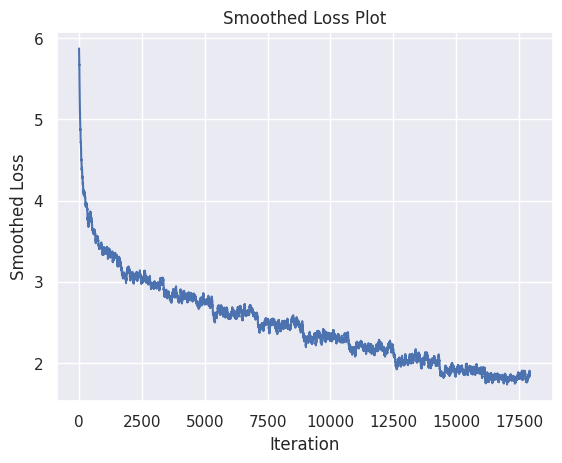

In [167]:
window_size = 50
smoothed_losses = []

# Iterate up to len(losses) - window_size + 1 to include the last smoothed value
for i in range(len(losses) - window_size + 1):
    smoothed_losses.append(np.mean(losses[i:i+window_size]))

# Plot the smoothed losses starting from the 100th element
plt.plot(smoothed_losses[100:])
plt.xlabel('Iteration')
plt.ylabel('Smoothed Loss')
plt.title('Smoothed Loss Plot')
plt.show()

In [168]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ja',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <jp>It has been confirmed that eight thoroughbred race horses at Randwick</s>


In [169]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

ランドウィス郡の8匹の競輪馬は、オーストラリアのクイーンズランド
ランドウィス郡の8匹の競輪馬が、オーストラリアのクイーンズランド
ランドウェスト郡の8匹の競輪馬は、オーストラリアのクイーンズランド


In [170]:
# Provided information
sentence_0 = "It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza."

# Given sequence with placeholders
sequence = "<extra_id_0> <extra_id_0>. <extra_id_0>.) <extra_id_10>.едет <extra_id_10> <extra_id_10>)on.on bulunduарамен次次ان次وا"

# Replace the placeholders with actual content
filled_sequence = sequence.replace("<extra_id_0>", sentence_0)
filled_sequence = filled_sequence.replace("<extra_id_10>", sentence_0)

print("Filled Sequence:", filled_sequence)

Filled Sequence: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza. It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.. It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza..) It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza..едет It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza. It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.)on.on bulunduарамен次次ان次وا


In [171]:
import nltk

def calculate_wer(reference, candidate):
    """
    Calculate Word Error Rate (WER) between reference and candidate.
    :param reference: list of reference words
    :param candidate: list of candidate words
    :return: Word Error Rate
    """
    align = nltk.edit_distance(reference, candidate)
    wer = align / len(reference)
    return wer

# Example usage:
reference_translation = ["your name"]
candidate_translation = ["Your name was asked, “What is your name?"]

wer_score = calculate_wer(reference_translation, candidate_translation)
print(f"Word Error Rate: {wer_score}")

Word Error Rate: 1.0


In [172]:
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [173]:
reference = ["your name"]
candidate = 'Your name was asked, “What is your name?”'

# Tokenize the sentences
reference_tokens = [nltk.word_tokenize(sent) for sent in reference]
candidate_tokens = nltk.word_tokenize(candidate)

# Calculate BLEU score
bleu_score = sentence_bleu(reference_tokens, candidate_tokens)

print("BLEU Score:", bleu_score)

BLEU Score: 5.233427736988301e-155


In [174]:
!pip install rouge

In [175]:
from rouge import Rouge

# Reference (ground truth) and candidate (generated) sentences
reference = ["your name"]
candidate = "Your name was asked, 'What is your name?'"

# Convert the reference list to a string
reference_str = ' '.join(reference)

# Initialize the Rouge object
rouge = Rouge()

# Calculate ROUGE scores
scores = rouge.get_scores(candidate, reference_str)

# Print the ROUGE scores
print("ROUGE Scores:")
print("ROUGE-1 Precision:", scores[0]["rouge-1"]["p"])
print("ROUGE-1 Recall:", scores[0]["rouge-1"]["r"])
print("ROUGE-1 F1 Score:", scores[0]["rouge-1"]["f"])

print("ROUGE-2 Precision:", scores[0]["rouge-2"]["p"])
print("ROUGE-2 Recall:", scores[0]["rouge-2"]["r"])
print("ROUGE-2 F1 Score:", scores[0]["rouge-2"]["f"])

print("ROUGE-L Precision:", scores[0]["rouge-l"]["p"])
print("ROUGE-L Recall:", scores[0]["rouge-l"]["r"])
print("ROUGE-L F1 Score:", scores[0]["rouge-l"]["f"])

ROUGE Scores:
ROUGE-1 Precision: 0.25
ROUGE-1 Recall: 1.0
ROUGE-1 F1 Score: 0.39999999680000003
ROUGE-2 Precision: 0.0
ROUGE-2 Recall: 0.0
ROUGE-2 F1 Score: 0.0
ROUGE-L Precision: 0.125
ROUGE-L Recall: 0.5
ROUGE-L F1 Score: 0.19999999680000002


In [176]:
import nltk

# Download the WordNet dataset
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [177]:
import nltk
from nltk.translate import meteor_score

# Download the WordNet dataset
nltk.download('wordnet')

# Reference (ground truth) and candidate (generated) sentences
reference = ["your name"]
candidate = "Your name was asked, 'What is your name?'"

# Tokenize the sentences
reference_tokens = [nltk.word_tokenize(sent) for sent in reference]
candidate_tokens = nltk.word_tokenize(candidate)

# Calculate METEOR score
meteor_score_value = meteor_score.meteor_score(reference_tokens, candidate_tokens)

# Print the METEOR score
print("METEOR Score:", meteor_score_value)


METEOR Score: 0.646551724137931


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
